In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, preprocessing, model_selection, metrics, base
import tensorflow as tf
import cv2

In [3]:
warnings.filterwarnings("ignore")

In [4]:
path = r"/content/drive/MyDrive/Data_AI/Train File/Train File"

images, labels = [], []

for file in sorted(os.listdir(path)):
    if file.endswith(".jpg") or file.endswith("jpeg"):
        img = cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(path, file)), (128, 128)), cv2.COLOR_BGR2RGB)
        images.append(img)
        if "Hog Pulm" in file:
            file = file.replace("Hog Pulm", "HogPlum")
        elif "HogPulm" in file:
            file = file.replace("HogPulm", "HogPlum")
        elif "Lichi" in file:
            file = file.replace("Lichi", "Litchi")
        labels.append(re.findall("[a-zA-Z]+", file)[0])

In [5]:
path = r"/content/drive/MyDrive/Data_AI/Test File/Test File"
for file in sorted(os.listdir(path)):
    if file.endswith(".jpg") or file.endswith(".jpeg"):
        img = cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(path, file)), (128, 128)), cv2.COLOR_BGR2RGB)
        images.append(img)
        labels.append(re.findall("[a-zA-Z]+", file)[0])

images = np.array(images)
labels = np.array(labels)

In [6]:
print(images.shape, labels.shape)

(400, 128, 128, 3) (400,)


In [7]:
class_names = np.unique(labels)

class_map = {i : class_name for i, class_name in enumerate(class_names)}
reverse_class_map = {val : key for key, val in class_map.items()}

print(class_map)

{0: 'Apple', 1: 'Banana', 2: 'Grapes', 3: 'Guava', 4: 'HogPlum', 5: 'Jackfruit', 6: 'Litchi', 7: 'Mango', 8: 'Orange', 9: 'Papaya'}


In [8]:
X = images.copy()
y = np.array([reverse_class_map[label] for label in labels.copy()])

In [9]:
def visualize():
    plt.figure(figsize = (12, 12))
    for i in range(9):
        img, label = X[i], y[i]
        plt.subplot(3, 3, i + 1)
        plt.title(class_map[label])
        plt.imshow(img)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

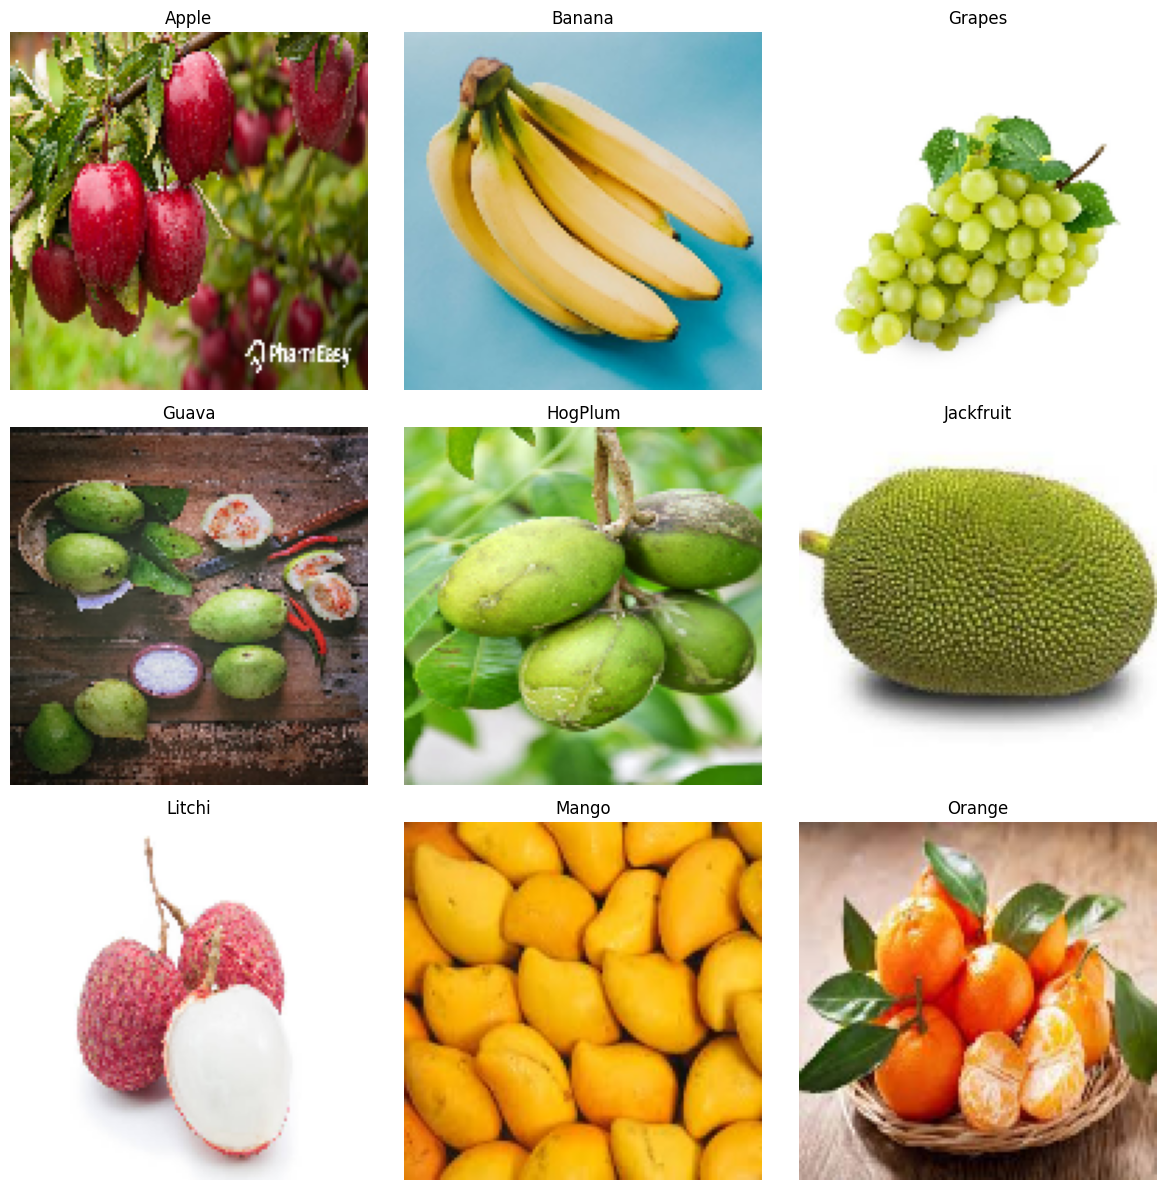

In [10]:
visualize()

In [11]:
# Image preprocessing ( Normalization )

print(X.min(), X.max())

X = X / 255.0
print(X.min(), X.max())

0 255
0.0 1.0


In [12]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

In [13]:
label_counts = pd.Series(y).value_counts()
label_counts

0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: count, dtype: int64

In [14]:
max_total = 500
X_new, y_new = [], []
X_cls_array = [X[y == i] for i in class_map.keys()]

for label, X_set in zip(class_map.keys(), X_cls_array):
    count = 0
    while count < max_total - label_counts[label]:
        for img in X_set:
            augmented_img = data_augmentation(np.expand_dims(img, axis = 0))
            X_new.append(augmented_img[0])
            y_new.append(label)
            count += 1
            if count >= max_total - label_counts[label]:
                break

X_new, y_new = np.array(X_new), np.array(y_new)
print(X_new.shape, y_new.shape)

(4600, 128, 128, 3) (4600,)


In [15]:
X = np.concatenate([X, X_new])
y = np.concatenate([y, y_new])

print(X.shape, y.shape)

print(pd.Series(y).value_counts())

(5000, 128, 128, 3) (5000,)
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: count, dtype: int64


In [16]:
# Splitting the data into training, testing and validation sets

X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(X, y, test_size = 0.1, stratify = y)
X_train, X_val, y_train, y_val = model_selection.train_test_split(X_train_val, y_train_val, test_size = 0.1, stratify = y_train_val)

print(X_train.shape, X_val.shape, X_test.shape)

(4050, 128, 128, 3) (450, 128, 128, 3) (500, 128, 128, 3)


In [17]:
# Checking whether the labels are uniformely distributed across the train and test sets

def test_uniformity(y_train, y_test, class_names):
    plt.figure(figsize = (15, 5))

    plt.subplot(1, 2, 1)
    plt.title("Training Set")
    plt.xticks(ticks = np.arange(len(class_names)))
    sns.histplot(y_train, bins = len(class_names))

    plt.subplot(1, 2, 2)
    plt.title("Testing Set")
    plt.xticks(ticks = np.arange(len(class_names)))
    sns.histplot(y_test, bins = len(class_names))

    plt.tight_layout()
    plt.show()

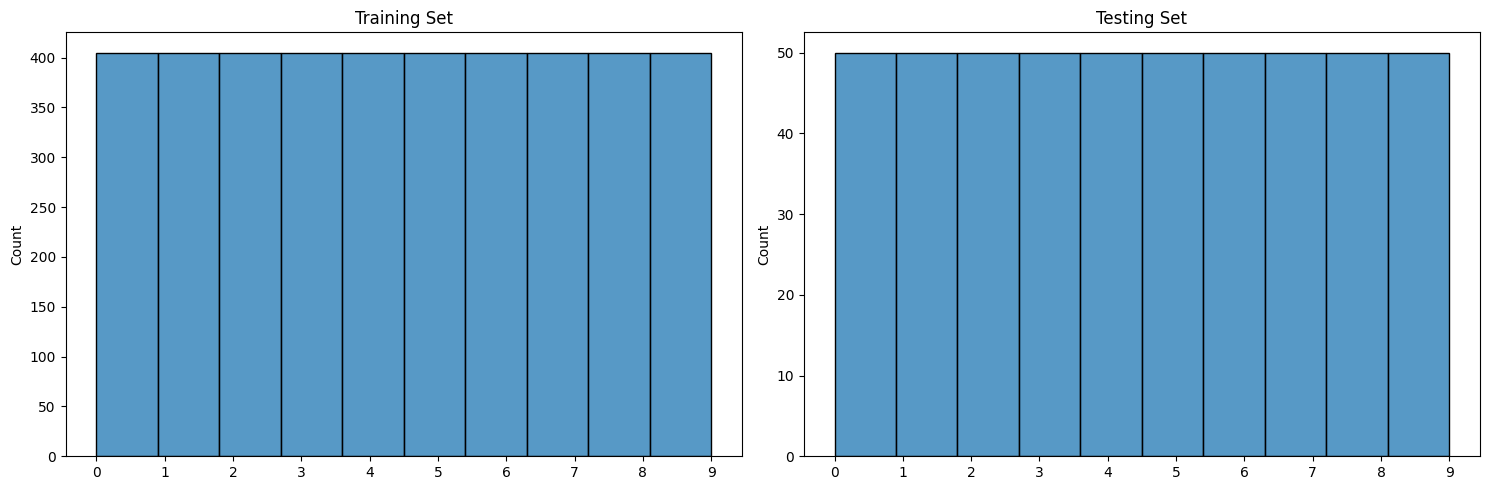

In [18]:
test_uniformity(y_train, y_test, class_names)

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.Conv2D(filters = 200, kernel_size = (5, 5), activation = "elu"),
    tf.keras.layers.MaxPool2D(pool_size = (5, 5)),
    tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), activation = "elu"),
    tf.keras.layers.MaxPool2D(pool_size = (3, 3)),
    tf.keras.layers.Conv2D(filters = 50, kernel_size = (3, 3), activation = "elu"),
    tf.keras.layers.MaxPool2D(pool_size = (3, 3)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 200, kernel_initializer = "he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.Dense(units = 100, kernel_initializer = "he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("elu"),
    tf.keras.layers.Dense(units = len(class_names), activation = "softmax")
])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 200)     15200     
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 200)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 100)       180100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 100)         0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 5, 50)          45050     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 50)         

In [21]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [22]:
cb1 = tf.keras.callbacks.EarlyStopping(patience = 25, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 100, validation_data = (X_val, y_val), callbacks = [cb1])

Epoch 1/100
127/127 [==============================] - 339s 3s/step - loss: 1.5676 - accuracy: 0.4578 - val_loss: 1.7913 - val_accuracy: 0.4067
Epoch 2/100
127/127 [==============================] - 347s 3s/step - loss: 1.0777 - accuracy: 0.6314 - val_loss: 1.8879 - val_accuracy: 0.4422
Epoch 3/100
127/127 [==============================] - 350s 3s/step - loss: 0.8536 - accuracy: 0.7044 - val_loss: 0.9744 - val_accuracy: 0.6311
Epoch 4/100
127/127 [==============================] - 337s 3s/step - loss: 0.6573 - accuracy: 0.7795 - val_loss: 1.1445 - val_accuracy: 0.6133
Epoch 5/100
127/127 [==============================] - 347s 3s/step - loss: 0.5174 - accuracy: 0.8212 - val_loss: 0.8998 - val_accuracy: 0.6933
Epoch 6/100
127/127 [==============================] - 344s 3s/step - loss: 0.4388 - accuracy: 0.8496 - val_loss: 1.0741 - val_accuracy: 0.6689
Epoch 7/100
127/127 [==============================] - 337s 3s/step - loss: 0.3177 - accuracy: 0.8985 - val_loss: 1.0420 - val_accuracy:

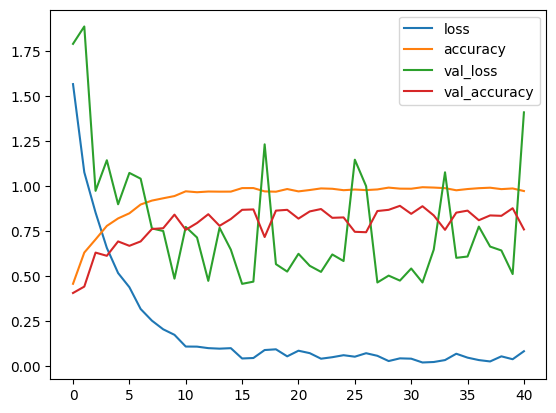

In [23]:
# Learning Curves ( Accuracy and Loss )

results_ = pd.DataFrame(history.history)
results_.plot()
plt.show()

In [24]:
# Evaluating the model on test set

loss, accuracy = model.evaluate(X_test, y_test)

print(loss, accuracy)

16/16 [==============================] - 13s 843ms/step - loss: 0.4066 - accuracy: 0.8820
0.4066144526004791 0.8820000290870667


16/16 [==============================] - 11s 676ms/step
              precision    recall  f1-score   support

           0   0.653333  0.980000  0.784000        50
           1   0.941176  0.960000  0.950495        50
           2   0.857143  0.960000  0.905660        50
           3   0.914894  0.860000  0.886598        50
           4   0.942857  0.660000  0.776471        50
           5   0.921569  0.940000  0.930693        50
           6   0.978723  0.920000  0.948454        50
           7   0.900000  0.720000  0.800000        50
           8   0.960784  0.980000  0.970297        50
           9   0.893617  0.840000  0.865979        50

    accuracy                       0.882000       500
   macro avg   0.896410  0.882000  0.881865       500
weighted avg   0.896410  0.882000  0.881865       500



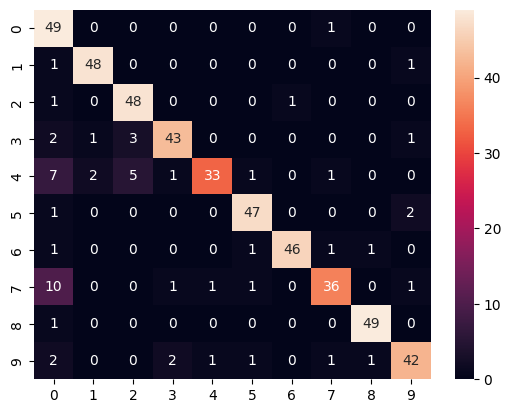

In [25]:
y_test_pred_probs = model.predict(X_test)

y_test_pred = np.array([np.argmax(res) for res in y_test_pred_probs])

clf_report = metrics.classification_report(y_test, y_test_pred, digits = 6)
print(clf_report)

conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix, annot = True)
plt.show()

In [26]:
model.save("final_model_1.h5")